In [1]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('SCMS_Delivery_History_Dataset.csv')

In [3]:
# Remove wrong entry data in Weight (Kilograms) and Freight Cost(USD) and convert into numerical column
df = df[(df['Weight (Kilograms)'] != 'Weight Captured Separately')]
df = df[(df['Freight Cost (USD)'] != 'Freight Included in Commodity Cost')]
df = df[(df['Freight Cost (USD)'] != 'Invoiced Separately')]

# Remove all rows that contain the text 'See' in the 'Weight (Kilograms)' and 'Freight Cost (USD)' columns
df = df[~df[['Weight (Kilograms)','Freight Cost (USD)']].apply(lambda row: row.astype(str).str.contains('See').any(), axis=1)]

In [4]:
# 'Weight (Kilograms)' and 'Freight Cost (USD)' into numeric
df[['Weight (Kilograms)', 'Freight Cost (USD)']] = df[['Weight (Kilograms)', 'Freight Cost (USD)']].apply(pd.to_numeric)

In [5]:
#Handling Missing Value
df['Shipment Mode'] = df['Shipment Mode'].fillna(df['Shipment Mode'].mode()[0])
df['Dosage'] = df['Dosage'].fillna(df['Dosage'].mode()[0])
df['Line Item Insurance (USD)'] = df['Line Item Insurance (USD)'].fillna(df['Line Item Insurance (USD)'].median())

In [6]:
# Combine Line Item Value, Line Item Insurance (USD) and Freight Cost (USD)
df['Total Cost']= df['Line Item Value'] + df['Line Item Insurance (USD)'] + df['Freight Cost (USD)']

In [7]:
df = df.drop(columns=['Line Item Value','Line Item Insurance (USD)','Freight Cost (USD)','PQ First Sent to Client Date','Delivery Recorded Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date'],axis=1)

In [8]:
# split data into train and test
from sklearn.model_selection import train_test_split

In [9]:
# Split data
X= df.drop(columns=['Total Cost'],axis=1)
y = df['Total Cost']

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
X.select_dtypes(include='object').columns

Index(['Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'Product Group', 'Sub Classification', 'Vendor', 'Item Description',
       'Molecule/Test Type', 'Brand', 'Dosage', 'Dosage Form',
       'Manufacturing Site', 'First Line Designation'],
      dtype='object')

In [12]:
# Encoding Categorical Column
X[['Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
        'Product Group', 'Sub Classification','Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Manufacturing Site', 'First Line Designation']] = X.select_dtypes(include='object').apply(LabelEncoder().fit_transform)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection using SelectKBest and f_regression
k_best_features = 25  # Set the number of top features you want to select
selector = SelectKBest(score_func=f_regression, k=k_best_features)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
print(selected_feature_names)

Selected features:
Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'Product Group', 'Sub Classification', 'Vendor', 'Item Description',
       'Molecule/Test Type', 'Brand', 'Dosage', 'Dosage Form',
       'Unit of Measure (Per Pack)', 'Line Item Quantity', 'Pack Price',
       'Unit Price', 'Manufacturing Site', 'First Line Designation',
       'Weight (Kilograms)'],
      dtype='object')


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [17]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'XGBRegressor': XGBRegressor()
}

param_grids = {
    'RandomForestRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'AdaBoostRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01]
    },
    'XGBRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5]
    }
}


In [18]:
best_model_list = []
best_feature_list = []
model_list = []
mae_list = []
rmse_list = []
r2_list = []


for model_name, model in models.items():
    # Hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name],
                               scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    # Get the best model with the tuned hyperparameters
    best_model = grid_search.best_estimator_

    # Make Predictions
    y_pred = best_model.predict(X_test_selected)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2_square = r2_score(y_test, y_pred)

    print(model_name)
    model_list.append(model_name)

    print('Model Training Performance')
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 score", r2_square * 100)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2_square)

    # Check feature importances (for models that support it)
    if hasattr(best_model, 'feature_importances_'):
        feature_importances = best_model.feature_importances_
        best_feature_list.append(dict(zip(list(X_train.columns), feature_importances)))
        print("Feature Importances:")
        print(dict(zip(list(X_train.columns), feature_importances)))
    else:
        best_feature_list.append(None)

    best_model_list.append(best_model)

    print('=' * 35)
    print('\n')


RandomForestRegressor
Model Training Performance
RMSE: 93001.8328857423
MAE: 30321.254136755586
R2 score 94.83956552003262
Feature Importances:
{'ID': 0.0016333501753491664, 'Project Code': 0.0004744381445512018, 'PQ #': 0.00045523779546462146, 'PO / SO #': 0.00026644796870791234, 'ASN/DN #': 0.0006976086233580475, 'Country': 0.0015580806701426125, 'Managed By': 0.0, 'Fulfill Via': 7.938860923375565e-05, 'Vendor INCO Term': 1.4001412788131073e-05, 'Shipment Mode': 0.00039076485505824663, 'Product Group': 6.136130280233123e-07, 'Sub Classification': 6.978410181824183e-07, 'Vendor': 6.866675832965944e-06, 'Item Description': 0.0002565912277873733, 'Molecule/Test Type': 0.00029937778841394397, 'Brand': 0.000312767777081508, 'Dosage': 0.00034996091393939245, 'Dosage Form': 1.562694369524433e-05, 'Unit of Measure (Per Pack)': 0.0003462748563194405, 'Line Item Quantity': 0.6536976290401914, 'Pack Price': 0.19666109282698827, 'Unit Price': 0.02131196524344163, 'Manufacturing Site': 0.00010255

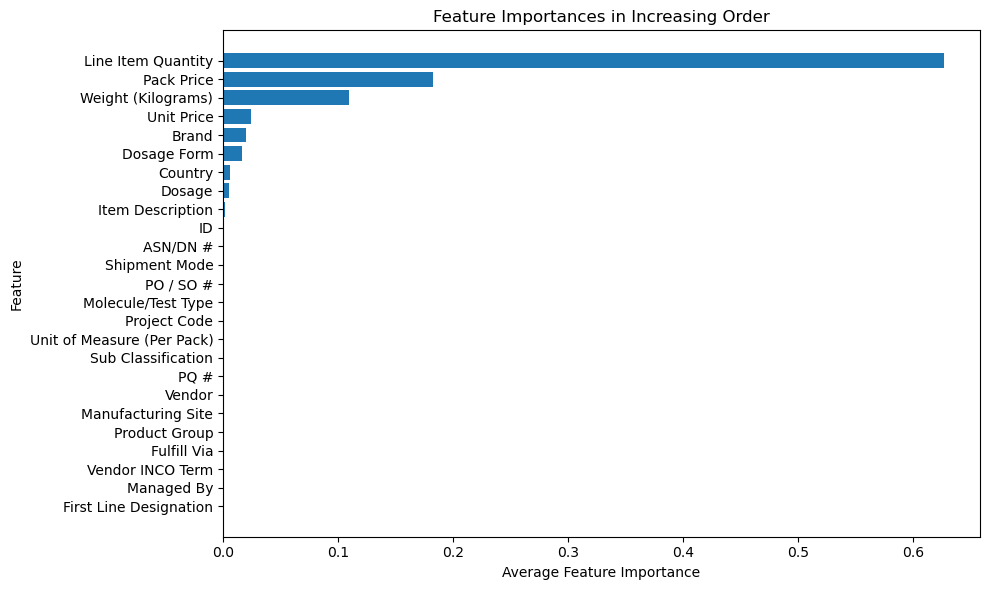

In [19]:
# Calculate the average feature importances across all best models
average_feature_importances = {}
for feature in best_feature_list[0].keys():
    average_importance = sum([d.get(feature, 0) for d in best_feature_list]) / len(best_feature_list)
    average_feature_importances[feature] = average_importance

# Sort the features based on their average importance in increasing order
sorted_features = sorted(average_feature_importances.items(), key=lambda x: x[1])

# Create a bar plot to visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), [importance for _, importance in sorted_features], align='center')
plt.yticks(range(len(sorted_features)), [feature for feature, _ in sorted_features])
plt.xlabel('Average Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Increasing Order')
plt.tight_layout()
plt.show()

Top 10 Best features in all model are :- 
1. Line Item Quantity 2. Pack Price 3. Weight (Kilograms) 4. Unit Price
5. Brand 6. Dosage Form7. Country 8. Dosage 9. Item Descriptions
10. PO/SO #

# XGBRegressor Give Best Result

In [20]:
# Tesing with Best features

X_train_best = X_train[['Line Item Quantity', 'Pack Price', 'Weight (Kilograms)', 'Unit Price','Brand','Dosage Form', 'Country','Dosage',
        'Item Description','PO / SO #']]
X_test_best = X_test[['Line Item Quantity', 'Pack Price', 'Weight (Kilograms)', 'Unit Price','Brand','Dosage Form', 'Country','Dosage',
        'Item Description','PO / SO #']]

In [21]:
print(X_train_best.shape)
print(X_test_best.shape)

(4940, 10)
(1235, 10)


RandomForestRegressor
Model Testing Performance
RMSE: 93039.06172704378
MAE: 29839.54107426437
R2 score 94.83543322623215


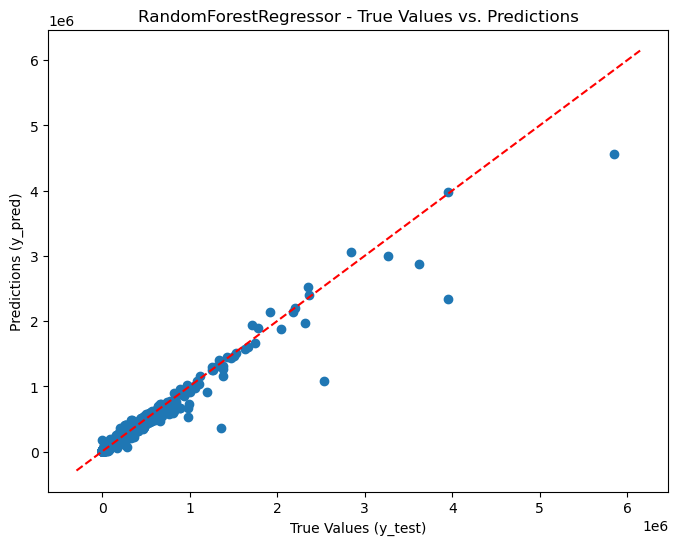



GradientBoostingRegressor
Model Testing Performance
RMSE: 69226.18405296438
MAE: 15011.029534823336
R2 score 97.14080327120675


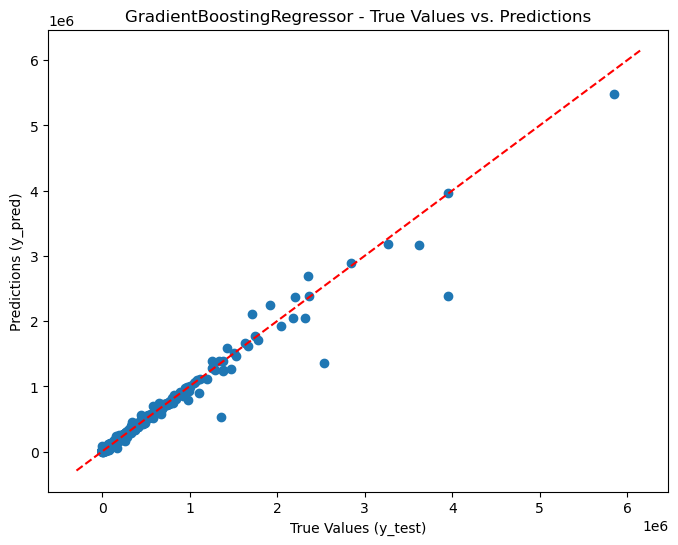



AdaBoostRegressor
Model Testing Performance
RMSE: 169706.1734235627
MAE: 110170.5383868312
R2 score 82.81701801161589


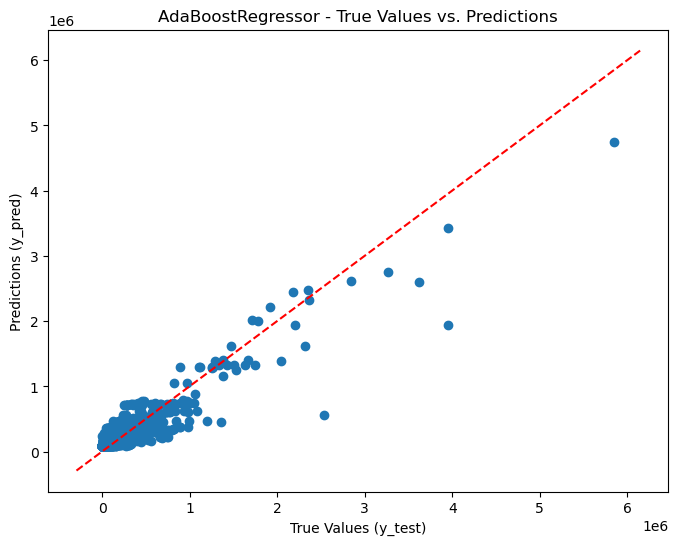



XGBRegressor
Model Testing Performance
RMSE: 62950.660880840434
MAE: 14299.574133245924
R2 score 97.63569314940634


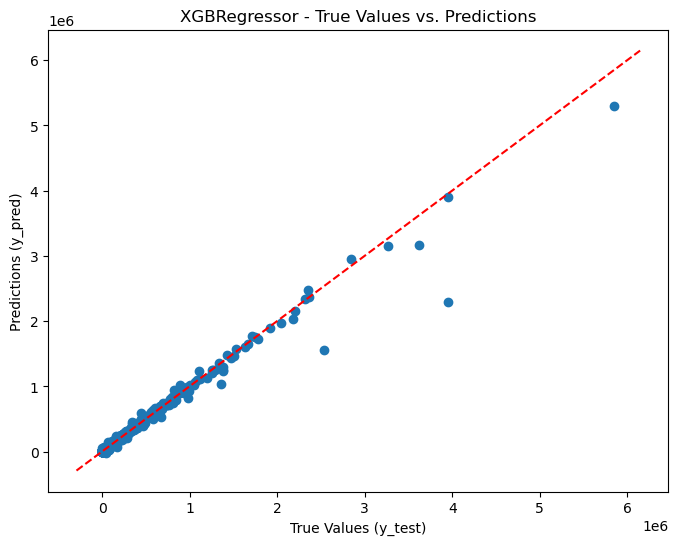

In [22]:
best_model_list = []
model_list = []
mae_list = []
rmse_list = []
r2_list = []

for model_name, model in models.items():
    # Hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name],
                               scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid_search.fit(X_train_best, y_train)

    # Get the best model with the tuned hyperparameters
    best_model = grid_search.best_estimator_

    # Make Predictions on the test data
    y_pred = best_model.predict(X_test_best)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2_square = r2_score(y_test, y_pred)

    print(model_name)
    model_list.append(model_name)

    print('Model Testing Performance')  # Changed from 'Model Training Performance'
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 score", r2_square * 100)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2_square)

    best_model_list.append(best_model)

    # Scatter plot y_test vs. y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    # Plot a line of perfect predictions (predicted = actual)
    perfect_preds = np.linspace(*plt.xlim())
    plt.plot(perfect_preds, perfect_preds, color='red', linestyle='--')
    
    plt.xlabel('True Values (y_test)')
    plt.ylabel('Predictions (y_pred)')
    plt.title(f'{model_name} - True Values vs. Predictions')
    plt.show()

    print('=' * 35)
    print('\n')

### After Applying top 10 best features

## XGBRegressor Give Best Result